<a href="https://colab.research.google.com/github/leoquiroa/TimeSeries/blob/master/ML_Approach_AdaBoostRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

#Prophet
from fbprophet import Prophet

#Keras
from keras.models import Sequential
from keras.layers import Dense

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [0]:
def read_raw_csv(url,nrows):
  df_doc = pd.read_csv(
      url, 
      nrows=nrows,
      names = ['date','cat','y'], 
      parse_dates = True )
  df_doc['date'] = pd.to_datetime(df_doc['date'])
  return df_doc

In [0]:
def filter_by(df_doc, name_doc):
  return df_doc[df_doc['cat'] == name_doc][['date','y']].reset_index(drop=True)

In [0]:
# Load the data
url = 'https://raw.githubusercontent.com/leoquiroa/TimeSeries/master/Data/daily_revenue_doctor.csv'
train = read_raw_csv(url, 4167)
times_series_means = filter_by(train, 'Robert Caputo')
times_series_means.head()

,date,y
0,2016-02-15,5472.11
1,2016-02-16,3248.52
2,2016-02-17,4977.18
3,2016-02-18,5482.26
4,2016-02-19,5495.88


In [0]:
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.reset_index(drop=True,inplace=True)
times_series_means.head()

,date,y,weekday,year,month,day
0,2016-02-15,5472.11,0,2016,02,15
1,2016-02-16,3248.52,1,2016,02,16
2,2016-02-17,4977.18,2,2016,02,17
3,2016-02-18,5482.26,3,2016,02,18
4,2016-02-19,5495.88,4,2016,02,19


In [0]:
def lag_func(data,lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.ix[1:, "diff"] = (data.iloc[1:, 1].as_matrix() - data.iloc[:len(data)-1, 1].as_matrix())
    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count,lag)
last_date = lagged['date'].max()
lagged.head()

,date,y,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-02-15,5472.11,0,2016,02,15,NaN,0.00,0.00,0.00,0.0,0.0,0.0,0.0
1,2016-02-16,3248.52,1,2016,02,16,-2223.59,NaN,0.00,0.00,0.0,0.0,0.0,0.0
2,2016-02-17,4977.18,2,2016,02,17,1728.66,-2223.59,NaN,0.00,0.0,0.0,0.0,0.0
3,2016-02-18,5482.26,3,2016,02,18,505.08,1728.66,-2223.59,NaN,0.0,0.0,0.0,0.0
4,2016-02-19,5495.88,4,2016,02,19,13.62,505.08,1728.66,-2223.59,NaN,0.0,0.0,0.0


In [0]:
# Train Test split
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

In [0]:
def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Modelisation with all product
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.as_matrix(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    # Model with all data
    model1.fit(xt, yt) 
    
    return model1, prediction, model0

model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

clr, prediction, clr0  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

-----------------------------------------------
mae with 70% of the data to train: 1378.6716445746688
-----------------------------------------------


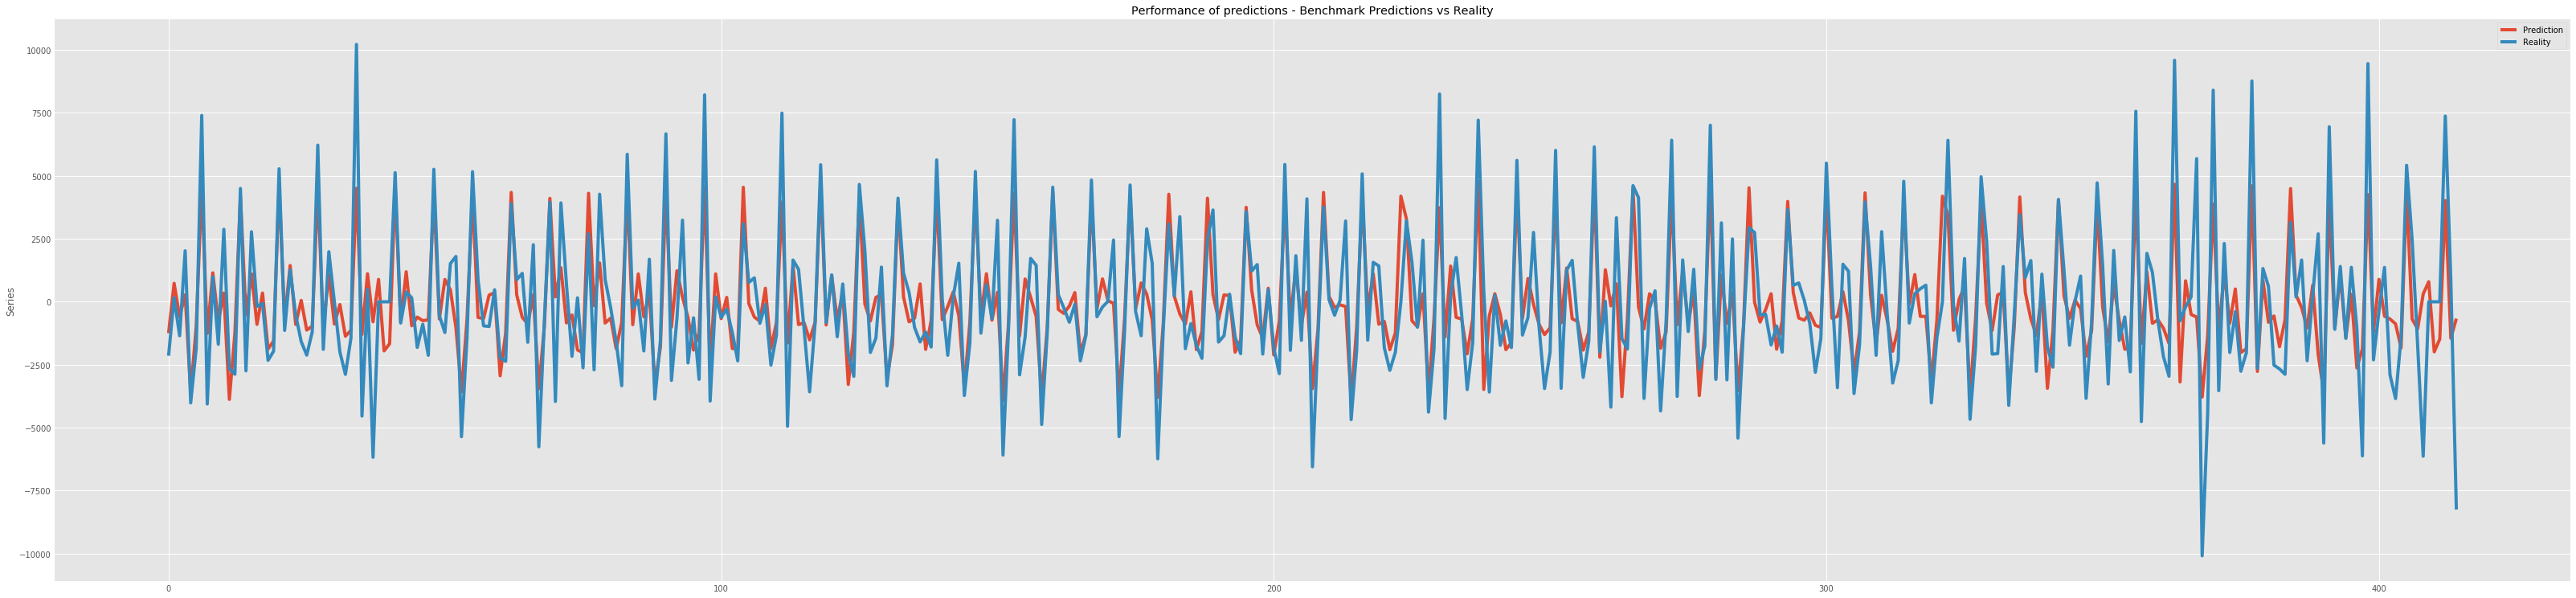

In [0]:
# Performance 1
plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

In [0]:
# Prediction
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)

In [0]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    # Initialisation
    model.fit(xtrain, ytrain)
    
    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]
        
        data_pred['weekday'] = data_pred['date'].apply(lambda x:x.weekday())
        weekday = data_pred['weekday'][0]
        
        row = pd.Series([lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,weekday]
                        ,['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        to_predict = pd.DataFrame(columns = ['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        prediction = pd.DataFrame(columns = ['diff'])
        to_predict = to_predict.append([row])
        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff'])

        # Loop
        if i == 0:
            last_predict = data_lag["y"][data_lag.shape[0]-1] + prediction.values[0][0]

        if i > 0 :
            last_predict = data_lag["y"][data_lag.shape[0]-1] + prediction.values[0][0]
        
        data_lag = pd.concat([data_lag,prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["y"][data_lag.shape[0]-1] = last_predict
        
        # test
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)
        
    return data_lag

model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

In [0]:
lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)
lagged.head()

,date,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,month,weekday,y,year
0,2016-02-15,15,NaN,0.00,0.00,0.00,0.0,0.0,0.0,0.0,NaN,02,0.0,5472.11,2016
1,2016-02-16,16,-2223.59,NaN,0.00,0.00,0.0,0.0,0.0,0.0,NaN,02,1.0,3248.52,2016
2,2016-02-17,17,1728.66,-2223.59,NaN,0.00,0.0,0.0,0.0,0.0,NaN,02,2.0,4977.18,2016
3,2016-02-18,18,505.08,1728.66,-2223.59,NaN,0.0,0.0,0.0,0.0,NaN,02,3.0,5482.26,2016
4,2016-02-19,19,13.62,505.08,1728.66,-2223.59,NaN,0.0,0.0,0.0,NaN,02,4.0,5495.88,2016


In [0]:
lagged[lagged['diff']<0]
lagged.ix[(lagged.y < 0), 'y'] = 0

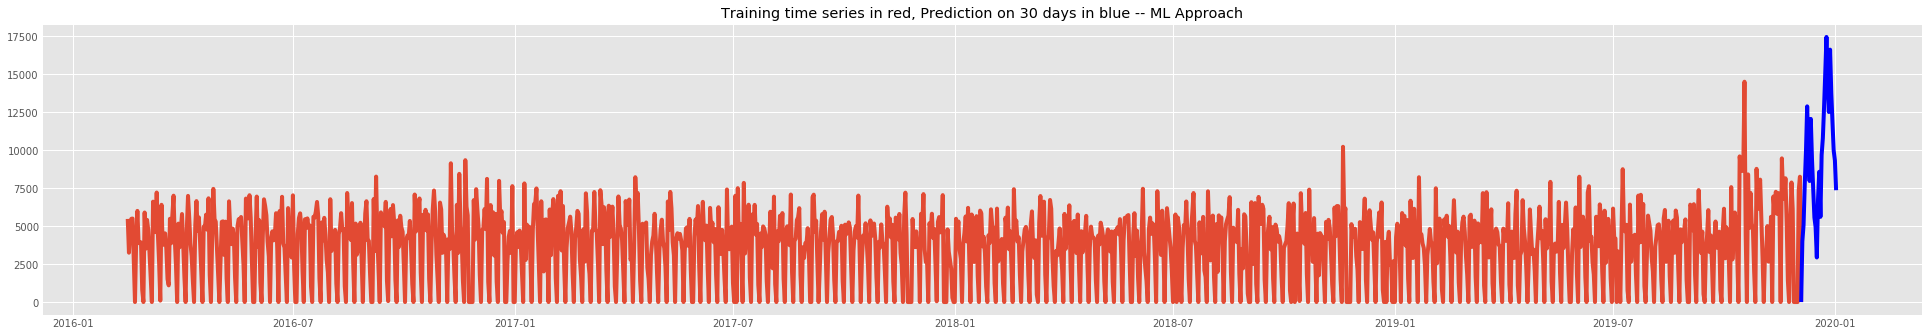

In [0]:
df_lagged = lagged[['y','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.y)
plt.plot(df_pred.date,df_pred.y,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()